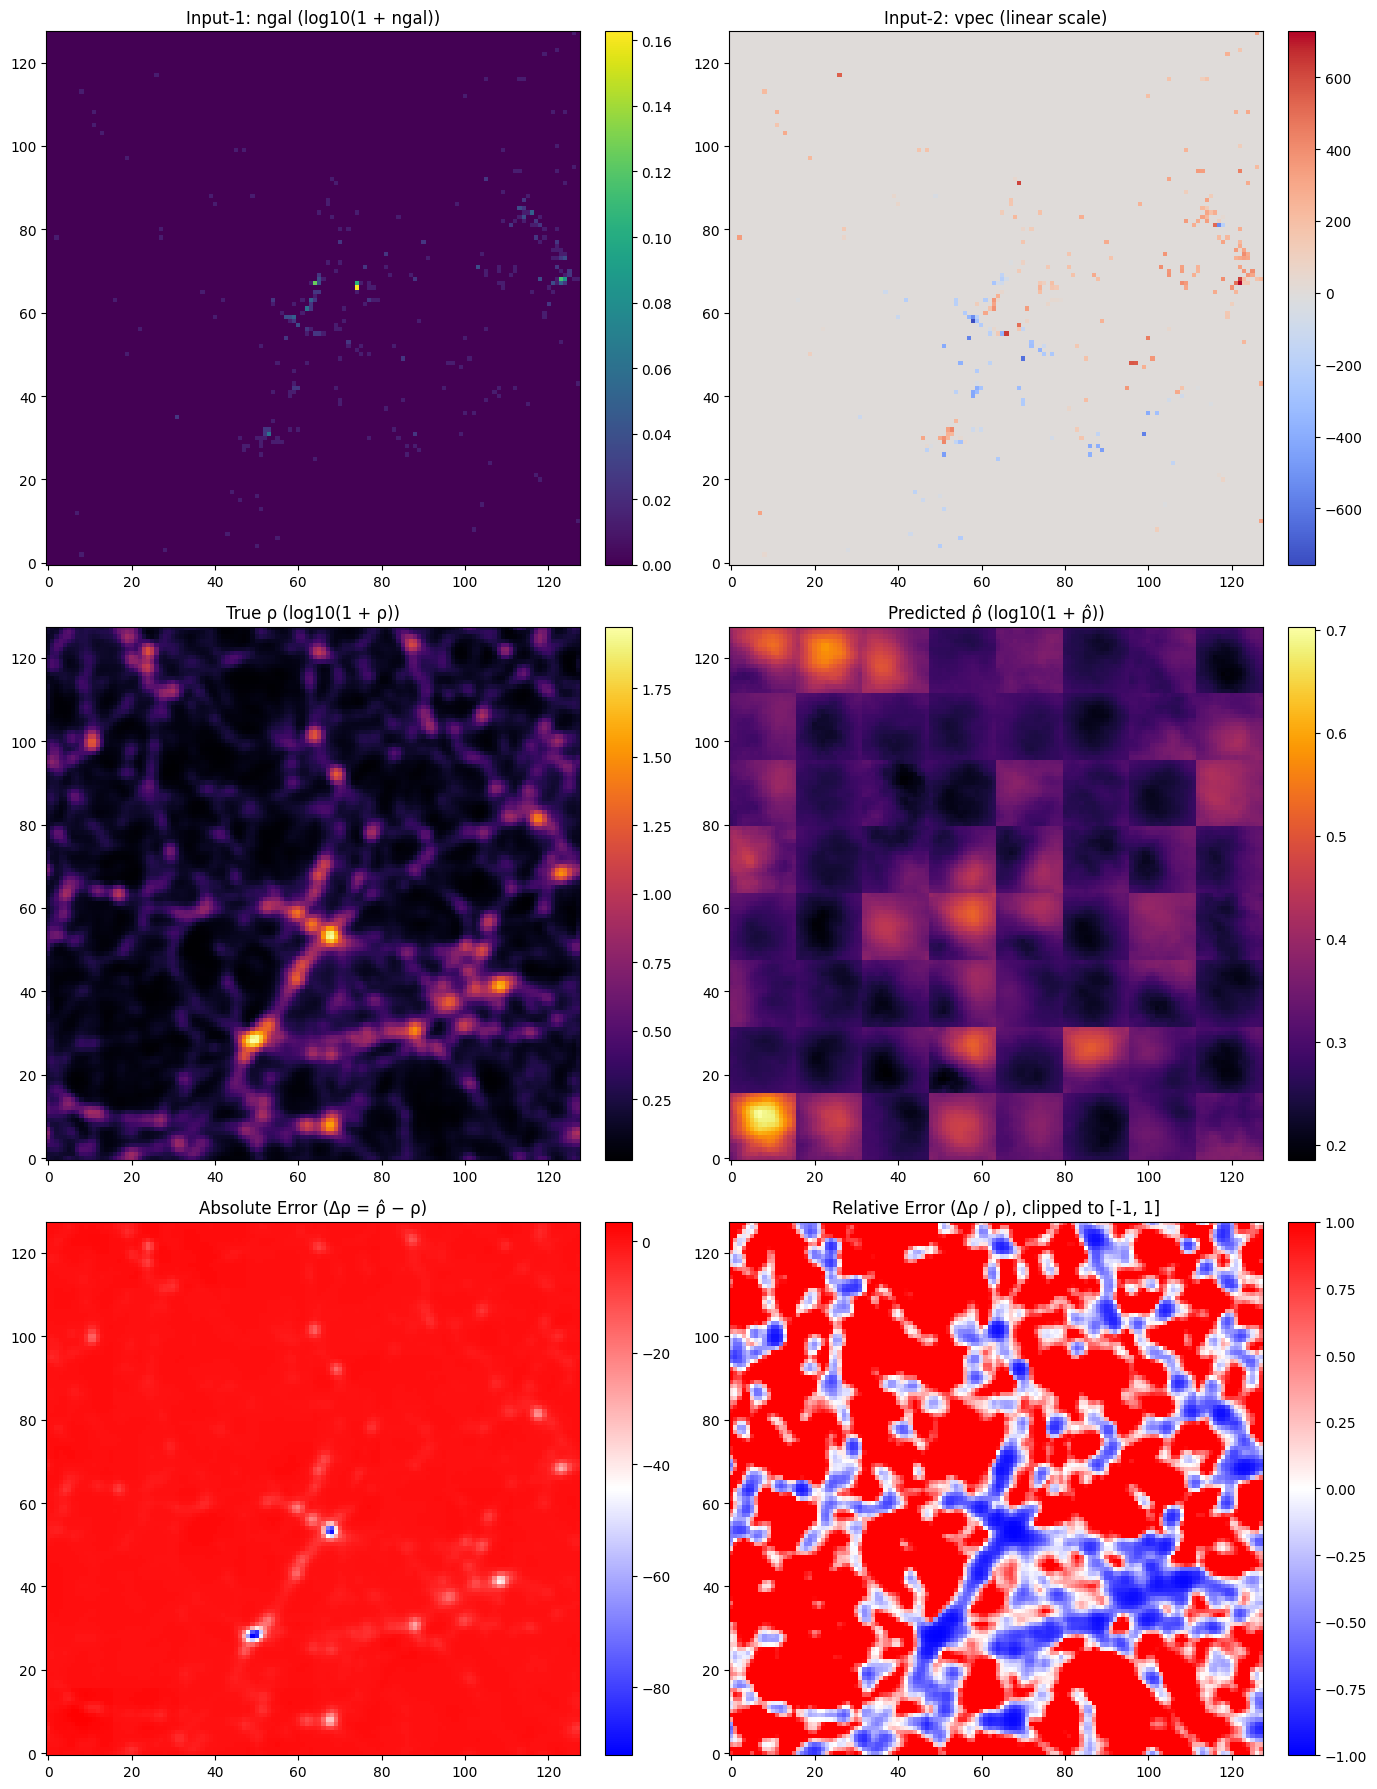

In [6]:
# viz_asim_pred.py
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 설정
# -------------------------------
INDEX = 100  # 시각화할 파일 인덱스 (예: test/100.hdf5)
TEST_FILE = f"/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test/{INDEX}.hdf5"

# 예측 결과 디렉토리 및 파일
PRED_DIR = "/home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251014_014505"
PRED_FILE = os.path.join(PRED_DIR, f"{INDEX}.hdf5")

# 어느 슬라이스를 볼지
SLICE_AXIS = 2               # 0: D, 1: H, 2: W
SLICE_INDEX_MODE = "center"  # "center" 또는 정수 인덱스

# -------------------------------
# 유틸
# -------------------------------
def _safesqueeze(arr):
    """앞뒤 불필요한 차원(길이 1)을 제거하되, 최소 3D는 유지."""
    a = np.squeeze(arr)
    if a.ndim < 3:
        raise ValueError(f"Unexpected ndim after squeeze: {a.ndim}, shape={a.shape}")
    return a

def _ensure_input_shape(x):
    """
    허용:
      (2, D, H, W)  또는
      (1, 2, D, H, W) 또는 (N, 2, D, H, W) 등
    반환:
      (2, D, H, W)
    """
    arr = x
    if arr.ndim == 4 and arr.shape[0] == 2:
        return arr
    if arr.ndim == 5 and arr.shape[0] == 1 and arr.shape[1] == 2:
        return arr[0]
    if arr.ndim == 5 and arr.shape[1] == 2:
        if arr.shape[0] != 1:
            raise ValueError(f"Got batch N={arr.shape[0]} > 1; 예상과 다릅니다.")
        return arr[0]
    if arr.ndim == 6 and arr.shape[1] == 1 and arr.shape[2] == 2:
        return np.squeeze(arr, axis=0)[0]  # (2,D,H,W)
    raise ValueError(f"Unsupported input shape: {arr.shape}")

def _get_slice(vol3d, axis=2, idx="center"):
    if idx == "center":
        idx = vol3d.shape[axis] // 2
    if axis == 0:
        return vol3d[idx, :, :]
    elif axis == 1:
        return vol3d[:, idx, :]
    elif axis == 2:
        return vol3d[:, :, idx]
    else:
        raise ValueError("axis must be 0,1,2")

def _log1p_safe(a):
    # 음수는 0으로 클립 → log1p 적용 (ngal, rho류에 적합)
    return np.log10(1.0 + np.clip(a, 0, None))

# -------------------------------
# 데이터 로드 (Truth & Inputs)
# -------------------------------
if not os.path.exists(TEST_FILE):
    raise FileNotFoundError(f"TEST_FILE not found: {TEST_FILE}")

with h5py.File(TEST_FILE, "r") as f:
    if "input" not in f:
        raise KeyError(f"'input' dataset not found in {TEST_FILE}")
    x = f["input"][:]                      # (1,2,D,H,W) or (2,D,H,W)
    x = _ensure_input_shape(x)             # (2,D,H,W)
    ngal = _safesqueeze(x[0])              # (D,H,W)
    vpec = _safesqueeze(x[1])              # (D,H,W)

    if "output_rho" not in f:
        raise KeyError(f"'output_rho' not found in {TEST_FILE}")
    rho_true = _safesqueeze(f["output_rho"][:])  # (D,H,W)

# -------------------------------
# 데이터 로드 (Prediction)
# -------------------------------
if not os.path.exists(PRED_FILE):
    raise FileNotFoundError(f"PRED_FILE not found: {PRED_FILE}")

with h5py.File(PRED_FILE, "r") as fp:
    if "prediction" not in fp:
        raise KeyError(f"'prediction' dataset not found in {PRED_FILE}")
    pred = fp["prediction"][:]             # (N,D,H,W) or (D,H,W)
    pred = _safesqueeze(pred)              # (D,H,W)

# -------------------------------
# 슬라이스 선택
# -------------------------------
ngal_slice = _get_slice(ngal, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
vpec_slice = _get_slice(vpec, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
rho_t_slice = _get_slice(rho_true, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
rho_p_slice = _get_slice(pred, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)

# -------------------------------
# Error maps
# -------------------------------
eps = 1e-6
abs_err_map = rho_p_slice - rho_t_slice
rel_err_map = (rho_p_slice - rho_t_slice) / (rho_t_slice + eps)

# -------------------------------
# 시각화 (3행 × 2열)
# -------------------------------
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
axes = axes.ravel()

# 1) Inputs
im0 = axes[0].imshow(_log1p_safe(ngal_slice), origin="lower", cmap="viridis")
axes[0].set_title("Input-1: ngal (log10(1 + ngal))")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# 주의: vpec는 부호 정보를 살리는 것이 유익할 수 있으므로 선형 스케일을 사용
im1 = axes[1].imshow(vpec_slice, origin="lower", cmap="coolwarm")
axes[1].set_title("Input-2: vpec (linear scale)")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# 2) Truth / Prediction
im2 = axes[2].imshow(_log1p_safe(rho_t_slice), origin="lower", cmap="inferno")
axes[2].set_title("True ρ (log10(1 + ρ))")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

im3 = axes[3].imshow(_log1p_safe(rho_p_slice), origin="lower", cmap="inferno")
axes[3].set_title("Predicted ρ̂ (log10(1 + ρ̂))")
plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)

# 3) Absolute / Relative error
im4 = axes[4].imshow(abs_err_map, origin="lower", cmap="bwr")
axes[4].set_title("Absolute Error (Δρ = ρ̂ − ρ)")
plt.colorbar(im4, ax=axes[4], fraction=0.046, pad=0.04)

im5 = axes[5].imshow(np.clip(rel_err_map, -1, 1), origin="lower", cmap="bwr", vmin=-1, vmax=1)
axes[5].set_title("Relative Error (Δρ / ρ), clipped to [-1, 1]")
plt.colorbar(im5, ax=axes[5], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [ ]:
# viz_asim_pred.py
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 설정
# -------------------------------
INDEX = 100  # 시각화할 파일 인덱스 (예: test/100.hdf5)
TEST_FILE = f"/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test/{INDEX}.hdf5"

# 예측 결과 디렉토리 및 파일
PRED_DIR = "/home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251014_024804"
PRED_FILE = os.path.join(PRED_DIR, f"{INDEX}.hdf5")

# 어느 슬라이스를 볼지
SLICE_AXIS = 2               # 0: D, 1: H, 2: W
SLICE_INDEX_MODE = "center"  # "center" 또는 정수 인덱스

# -------------------------------
# 유틸
# -------------------------------
def _safesqueeze(arr):
    """앞뒤 불필요한 차원(길이 1)을 제거하되, 최소 3D는 유지."""
    a = np.squeeze(arr)
    if a.ndim < 3:
        raise ValueError(f"Unexpected ndim after squeeze: {a.ndim}, shape={a.shape}")
    return a

def _ensure_input_shape(x):
    """
    허용:
      (2, D, H, W)  또는
      (1, 2, D, H, W) 또는 (N, 2, D, H, W) 등
    반환:
      (2, D, H, W)
    """
    arr = x
    if arr.ndim == 4 and arr.shape[0] == 2:
        return arr
    if arr.ndim == 5 and arr.shape[0] == 1 and arr.shape[1] == 2:
        return arr[0]
    if arr.ndim == 5 and arr.shape[1] == 2:
        if arr.shape[0] != 1:
            raise ValueError(f"Got batch N={arr.shape[0]} > 1; 예상과 다릅니다.")
        return arr[0]
    if arr.ndim == 6 and arr.shape[1] == 1 and arr.shape[2] == 2:
        return np.squeeze(arr, axis=0)[0]  # (2,D,H,W)
    raise ValueError(f"Unsupported input shape: {arr.shape}")

def _get_slice(vol3d, axis=2, idx="center"):
    if idx == "center":
        idx = vol3d.shape[axis] // 2
    if axis == 0:
        return vol3d[idx, :, :]
    elif axis == 1:
        return vol3d[:, idx, :]
    elif axis == 2:
        return vol3d[:, :, idx]
    else:
        raise ValueError("axis must be 0,1,2")

def _log1p_safe(a):
    # 음수는 0으로 클립 → log1p 적용 (ngal, rho류에 적합)
    return np.log10(1.0 + np.clip(a, 0, None))

# -------------------------------
# 데이터 로드 (Truth & Inputs)
# -------------------------------
if not os.path.exists(TEST_FILE):
    raise FileNotFoundError(f"TEST_FILE not found: {TEST_FILE}")

with h5py.File(TEST_FILE, "r") as f:
    if "input" not in f:
        raise KeyError(f"'input' dataset not found in {TEST_FILE}")
    x = f["input"][:]                      # (1,2,D,H,W) or (2,D,H,W)
    x = _ensure_input_shape(x)             # (2,D,H,W)
    ngal = _safesqueeze(x[0])              # (D,H,W)
    vpec = _safesqueeze(x[1])              # (D,H,W)

    if "output_rho" not in f:
        raise KeyError(f"'output_rho' not found in {TEST_FILE}")
    rho_true = _safesqueeze(f["output_rho"][:])  # (D,H,W)

# -------------------------------
# 데이터 로드 (Prediction)
# -------------------------------
if not os.path.exists(PRED_FILE):
    raise FileNotFoundError(f"PRED_FILE not found: {PRED_FILE}")

with h5py.File(PRED_FILE, "r") as fp:
    if "prediction" not in fp:
        raise KeyError(f"'prediction' dataset not found in {PRED_FILE}")
    pred = fp["prediction"][:]             # (N,D,H,W) or (D,H,W)
    pred = _safesqueeze(pred)              # (D,H,W)

# -------------------------------
# 슬라이스 선택
# -------------------------------
ngal_slice = _get_slice(ngal, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
vpec_slice = _get_slice(vpec, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
rho_t_slice = _get_slice(rho_true, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
rho_p_slice = _get_slice(pred, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)

# -------------------------------
# Error maps
# -------------------------------
eps = 1e-6
abs_err_map = rho_p_slice - rho_t_slice
rel_err_map = (rho_p_slice - rho_t_slice) / (rho_t_slice + eps)

# -------------------------------
# 시각화 (3행 × 2열)
# -------------------------------
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
axes = axes.ravel()

# 1) Inputs
im0 = axes[0].imshow(_log1p_safe(ngal_slice), origin="lower", cmap="viridis")
axes[0].set_title("Input-1: ngal (log10(1 + ngal))")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# 주의: vpec는 부호 정보를 살리는 것이 유익할 수 있으므로 선형 스케일을 사용
im1 = axes[1].imshow(vpec_slice, origin="lower", cmap="coolwarm")
axes[1].set_title("Input-2: vpec (linear scale)")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# 2) Truth / Prediction
im2 = axes[2].imshow(_log1p_safe(rho_t_slice), origin="lower", cmap="inferno")
axes[2].set_title("True ρ (log10(1 + ρ))")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

im3 = axes[3].imshow(_log1p_safe(rho_p_slice), origin="lower", cmap="inferno")
axes[3].set_title("Predicted ρ̂ (log10(1 + ρ̂))")
plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)

# 3) Absolute / Relative error
im4 = axes[4].imshow(abs_err_map, origin="lower", cmap="bwr")
axes[4].set_title("Absolute Error (Δρ = ρ̂ − ρ)")
plt.colorbar(im4, ax=axes[4], fraction=0.046, pad=0.04)

im5 = axes[5].imshow(np.clip(rel_err_map, -1, 1), origin="lower", cmap="bwr", vmin=-1, vmax=1)
axes[5].set_title("Relative Error (Δρ / ρ), clipped to [-1, 1]")
plt.colorbar(im5, ax=axes[5], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
